In [1]:
## https://github.com/ThomasDelteil/TextClassificationCNN_MXNet/blob/master/Crepe-Gluon.ipynb

In [2]:
import pickle
import gzip

In [3]:
with gzip.open('data_sets.pickle', 'r') as f:
    data = pickle.load(f)

In [4]:
import numpy as np

In [5]:
## Shuffle

In [6]:
np.random.seed(1234)
shuffle_indices = np.random.permutation(np.arange(len(data)))
data = data.iloc[shuffle_indices]

In [7]:
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon.data import ArrayDataset
from mxnet.gluon.data import DataLoader
import numpy as np
import multiprocessing

In [8]:
np.percentile([len(i) for i in data.X], range(0, 100, 10))

array([  2.,  46.,  65.,  81.,  95., 109., 122., 138., 156., 179.])

In [9]:
ALPHABET = list("abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+ =<>()[]{}") # The 69 characters as specified in the paper
ALPHABET_INDEX = {letter: index for index, letter in enumerate(ALPHABET)} # { a: 0, b: 1, etc}
NUM_WORKERS = multiprocessing.cpu_count() - 1# number of workers used in the data loading
BATCH_SIZE = 128 # number of documents per batch
FEATURE_LEN = 150

In [10]:
## Encoding

In [11]:
def encode(text):
    encoded = np.zeros([len(ALPHABET), FEATURE_LEN], dtype='float32')
    review = text.lower()[:FEATURE_LEN-1:-1] ## 뒤에서 자름
    i = 0
    for letter in text:
        if i >= FEATURE_LEN:
            break;
        if letter in ALPHABET_INDEX:
            encoded[ALPHABET_INDEX[letter]][i] = 1 ## 출현하는 알파벳에 +1
        i += 1
    return encoded

In [12]:
class MovieReviewDataSet(ArrayDataset):
    # We pre-process the documents on the fly
    def __getitem__(self, idx):
        return encode(self._data[0][idx]), self._data[1][idx]

In [13]:
split = 0.8
split_index = int(split*len(data))
train_data_X = data['X'][:split_index].values
train_data_Y = data['Y'][:split_index].values
test_data_X = data['X'][split_index:].values
test_data_Y = data['Y'][split_index:].values
train_dataset = MovieReviewDataSet(train_data_X, train_data_Y)
test_dataset = MovieReviewDataSet(test_data_X, test_data_Y)

In [14]:
train_data_X[0]

'the script manages the rare trick of seeming at once both refreshingly different and reassuringly familiar'

In [15]:
len(train_data_X[0])

106

In [16]:
sam_encdoded = encode(train_data_X[0])

In [17]:
np.shape(sam_encdoded) ## ALPHABET_LEN, FEATURE_LEN

(69, 150)

In [18]:
sam_encdoded[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [19]:
np.where(sam_encdoded[0] == 1)

(array([ 12,  14,  24,  45,  81,  87,  99, 104]),)

In [20]:
[idx for idx, i in enumerate(train_data_X[0]) if i == 'a']

[12, 14, 24, 45, 81, 87, 99, 104]

In [21]:
from collections import Counter

In [22]:
Counter(train_data_Y)

Counter({1: 4273, 0: 4256})

In [23]:
Counter(test_data_Y)

Counter({1: 1058, 0: 1075})

In [24]:
np.shape(train_dataset)

(8529, 2)

In [25]:
np.shape(test_dataset)

(2133, 2)

In [26]:
BATCH_SIZE = 128

In [27]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, last_batch='discard')

In [28]:
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, last_batch='discard')

In [29]:
categories = list(set(np.concatenate((train_data_Y, test_data_Y), axis=0)))

In [30]:
NUM_FILTERS = 128 # number of convolutional filters per convolutional layer
NUM_OUTPUTS = len(categories) # number of classes
FULLY_CONNECTED = 100 # number of unit in the fully connected dense layer
DROPOUT_RATE = 0.5 # probability of node drop out
LEARNING_RATE = 0.01 # learning rate of the gradient
MOMENTUM = 0.9 # momentum of the gradient
WDECAY = 0.00001 # regularization term to limit size of weights

In [31]:
net = gluon.nn.HybridSequential()
with net.name_scope():
    net.add(gluon.nn.Conv1D(channels=NUM_FILTERS, kernel_size=3, activation='relu'))
    net.add(gluon.nn.MaxPool1D(pool_size=3, strides=1))
    net.add(gluon.nn.Conv1D(channels=NUM_FILTERS, kernel_size=3, activation='relu'))
    net.add(gluon.nn.MaxPool1D(pool_size=3, strides=1))
    net.add(gluon.nn.Conv1D(channels=NUM_FILTERS, kernel_size=3, activation='relu'))
    net.add(gluon.nn.Conv1D(channels=NUM_FILTERS, kernel_size=3, activation='relu'))
    net.add(gluon.nn.Conv1D(channels=NUM_FILTERS, kernel_size=3, activation='relu'))
    net.add(gluon.nn.Conv1D(channels=NUM_FILTERS, kernel_size=3, activation='relu'))
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(FULLY_CONNECTED, activation='relu', flatten=False))
    net.add(gluon.nn.Dropout(DROPOUT_RATE))
    net.add(gluon.nn.Dense(FULLY_CONNECTED, activation='relu'))
    net.add(gluon.nn.Dropout(DROPOUT_RATE))
    net.add(gluon.nn.Dense(NUM_OUTPUTS))

In [32]:
print(net)

HybridSequential(
  (0): Conv1D(None -> 128, kernel_size=(3,), stride=(1,), Activation(relu))
  (1): MaxPool1D(size=(3,), stride=(1,), padding=(0,), ceil_mode=False)
  (2): Conv1D(None -> 128, kernel_size=(3,), stride=(1,), Activation(relu))
  (3): MaxPool1D(size=(3,), stride=(1,), padding=(0,), ceil_mode=False)
  (4): Conv1D(None -> 128, kernel_size=(3,), stride=(1,), Activation(relu))
  (5): Conv1D(None -> 128, kernel_size=(3,), stride=(1,), Activation(relu))
  (6): Conv1D(None -> 128, kernel_size=(3,), stride=(1,), Activation(relu))
  (7): Conv1D(None -> 128, kernel_size=(3,), stride=(1,), Activation(relu))
  (8): Flatten
  (9): Dense(None -> 100, Activation(relu))
  (10): Dropout(p = 0.5, axes=())
  (11): Dense(None -> 100, Activation(relu))
  (12): Dropout(p = 0.5, axes=())
  (13): Dense(None -> 2, linear)
)


In [33]:
net.hybridize()

In [34]:
shape = (1, 69, 150)

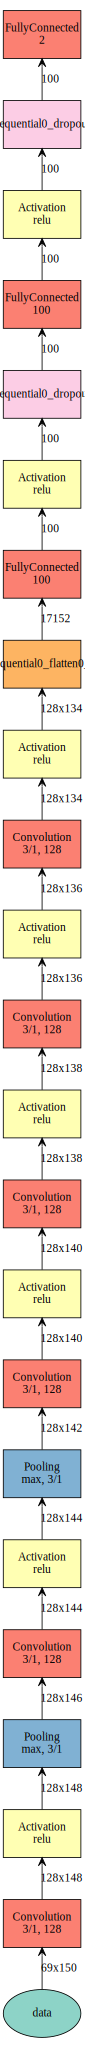

In [35]:
mx.viz.plot_network(
    net(mx.sym.var('data')), 
    shape={'data':shape}
)

In [36]:
mx.viz.print_summary(
    net(mx.sym.var('data')), 
    shape={'data':shape}
)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                          69x150                  0                                           
________________________________________________________________________________________________________________________
hybridsequential0_conv0_fwd(Convolution)            128x148                 26624       data                            
________________________________________________________________________________________________________________________
hybridsequential0_conv0_relu_fwd(Activation)        128x148                 0           hybridsequential0_conv0_fwd     
________________________________________________________________________________________________________________________
hybridsequential0_pool0_fwd(Pool

In [37]:
 ## Output Size
#(W - F_w + 2*P)/S_w + 1  : W = 폭, F = 필터 폭, P = padding 사이즈, S = Stride 사이즈 : (150 - 3 + 2*0)/1 + 1 = 148

In [79]:
# (F_o  * F_i * F_w * F_h) + F_o (Bias) : F_o = 아웃풋 채널수(필터수) , F_i = 인풋 채널수,  F_w = 필터 가로폭, F_h = 필터 세로폭
## 여기서 인풋 채널 수는 데이터 길이
26624 == (128 * 69 * 3 * 1) + 128

True

In [38]:
ctx = mx.gpu()

In [39]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.predict_mode():
            output = net(data)
        
        prediction = nd.argmax(output, axis=1)
        
        if (i%20 == 0):
            print("Samples {}".format(i*len(data)))
        acc.update(preds=prediction, labels=label)
    return acc.get()[1]

In [40]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [41]:
start_epoch = 0
number_epochs = 150
smoothing_constant=0.01

In [42]:
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)    
trainer = gluon.Trainer(net.collect_params(), 'sgd', 
                  {'learning_rate': LEARNING_RATE,
                  'wd':WDECAY, 
                   'momentum':MOMENTUM})

train_accuracy = mx.metric.Accuracy()

for e in range(start_epoch, number_epochs):
    
    if e % 100 == 0:
        trainer.set_learning_rate(trainer.learning_rate * 0.9)
    
    for i, (review, label) in enumerate(train_dataloader):
        review = review.as_in_context(ctx)
        label = label.as_in_context(ctx)

        with autograd.record(train_mode=True):
            output = net(review)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(review.shape[0])

        prediction = nd.argmax(output, axis=1)
        train_accuracy.update(preds=prediction, labels=label)

        # moving average of the loss
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if (i == 0) 
                       else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)


    train_accuracy.update(preds=prediction, labels=label)
    test_accuracy = evaluate_accuracy(test_dataloader, net)

    print("Epoch %s. Loss: %s, Training_acc %s" % (e, round(moving_loss, 4), round(train_accuracy.get()[1],4)))
    print("Epoch %s. Loss: %s, Test_acc %s" % (e, round(moving_loss, 4), round(test_accuracy,4)))

Samples 0
Epoch 0. Loss: 0.6934, Training_acc 0.485
Epoch 0. Loss: 0.6934, Test_acc 0.4961
Samples 0
Epoch 1. Loss: 0.6941, Training_acc 0.491
Epoch 1. Loss: 0.6941, Test_acc 0.5044
Samples 0
Epoch 2. Loss: 0.6933, Training_acc 0.493
Epoch 2. Loss: 0.6933, Test_acc 0.5078
Samples 0
Epoch 3. Loss: 0.6927, Training_acc 0.4931
Epoch 3. Loss: 0.6927, Test_acc 0.499
Samples 0
Epoch 4. Loss: 0.6929, Training_acc 0.4942
Epoch 4. Loss: 0.6929, Test_acc 0.5142
Samples 0
Epoch 5. Loss: 0.6929, Training_acc 0.495
Epoch 5. Loss: 0.6929, Test_acc 0.5059
Samples 0
Epoch 6. Loss: 0.6931, Training_acc 0.4954
Epoch 6. Loss: 0.6931, Test_acc 0.5083
Samples 0
Epoch 7. Loss: 0.6925, Training_acc 0.4966
Epoch 7. Loss: 0.6925, Test_acc 0.5034
Samples 0
Epoch 8. Loss: 0.694, Training_acc 0.4973
Epoch 8. Loss: 0.694, Test_acc 0.4946
Samples 0
Epoch 9. Loss: 0.6921, Training_acc 0.4978
Epoch 9. Loss: 0.6921, Test_acc 0.5098
Samples 0
Epoch 10. Loss: 0.6938, Training_acc 0.4982
Epoch 10. Loss: 0.6938, Test_acc 

Samples 0
Epoch 88. Loss: 0.6134, Training_acc 0.5435
Epoch 88. Loss: 0.6134, Test_acc 0.4966
Samples 0
Epoch 89. Loss: 0.6956, Training_acc 0.543
Epoch 89. Loss: 0.6956, Test_acc 0.5005
Samples 0
Epoch 90. Loss: 0.6963, Training_acc 0.5425
Epoch 90. Loss: 0.6963, Test_acc 0.5054
Samples 0
Epoch 91. Loss: 0.6923, Training_acc 0.5421
Epoch 91. Loss: 0.6923, Test_acc 0.5098
Samples 0
Epoch 92. Loss: 0.6931, Training_acc 0.5418
Epoch 92. Loss: 0.6931, Test_acc 0.5024
Samples 0
Epoch 93. Loss: 0.6935, Training_acc 0.5415
Epoch 93. Loss: 0.6935, Test_acc 0.5171
Samples 0
Epoch 94. Loss: 0.6927, Training_acc 0.5413
Epoch 94. Loss: 0.6927, Test_acc 0.5391
Samples 0
Epoch 95. Loss: 0.6894, Training_acc 0.5414
Epoch 95. Loss: 0.6894, Test_acc 0.5479
Samples 0
Epoch 96. Loss: 0.6922, Training_acc 0.5415
Epoch 96. Loss: 0.6922, Test_acc 0.5044
Samples 0
Epoch 97. Loss: 0.7012, Training_acc 0.5412
Epoch 97. Loss: 0.7012, Test_acc 0.5156
Samples 0
Epoch 98. Loss: 0.6968, Training_acc 0.5408
Epoch 9

In [43]:
#OVER 0.65

In [44]:
net.export('char-cnn')

In [45]:
model = gluon.nn.SymbolBlock.imports("char-cnn-symbol.json", ['data'], "char-cnn-0000.params")

In [46]:
categories = list(categories)

In [47]:
data['X'][5]

'the film provides some great insight into the neurotic mindset of all comics even those who have reached the absolute top of the game'

In [48]:
data['Y'][5]

1

In [49]:
import random
index = 20 #random.randint(1, len(data))
review = data['X'][index]
label = categories[int(data['Y'][index])]
print(review)
print('\nCategory: {}\n'.format(label))
encoded = nd.array([encode(review)], ctx=ctx)
output = net(encoded)
predicted = categories[np.argmax(output[0].asnumpy())]
if predicted == label:
      print('Correct')
else:
      print('Incorrectly predicted {}'.format(predicted))

a thoughtful , provocative , insistently humanizing film

Category: 1

Correct


In [50]:
def predict_sentiment(model, review):
    print(review + '\n')
    encoded = nd.array([encode(review)], ctx=mx.cpu())
    output = model(encoded)
    softmax = nd.exp(output) / nd.sum(nd.exp(output))[0]
    predicted = categories[np.argmax(output[0].asnumpy())]
    print('Predicted: {}\n'.format(predicted))
    for i, val in enumerate(categories):
        print(val, float(int(softmax[0][i].asnumpy()*1000)/10), '%')

In [51]:
predict_sentiment(model, 'the movie gives')

the movie gives

Predicted: 1

0 22.4 %
1 77.5 %


In [52]:
predict_sentiment(model, 'the movie gives good insights')

the movie gives good insights

Predicted: 1

0 8.1 %
1 91.8 %


In [53]:
predict_sentiment(model, 'the movie gives the best insight')

the movie gives the best insight

Predicted: 1

0 0.0 %
1 99.9 %


In [74]:
predict_sentiment(model, 'the movie was amazing')

the movie was amazing

Predicted: 1

0 4.4 %
1 95.5 %


In [55]:
predict_sentiment(model, 'the movie was bad')

the movie was bad

Predicted: 0

0 89.0 %
1 10.9 %


## Model Serve

In [56]:
#https://github.com/awslabs/mxnet-model-server/tree/master/examples/gluon_character_cnn